# Building elastic net models with PyTorch
This post will explore building elastic net models using the PyTorch library.
I will compare various scenarios with the implementations in scikit-learn to validate them.

Start by importing stuff:

In [1]:
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

Let's generate some data with some 0 coefficients, which would be an ideal case for a Lasso model:

<ipython-input-2-2030eccf1f76>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


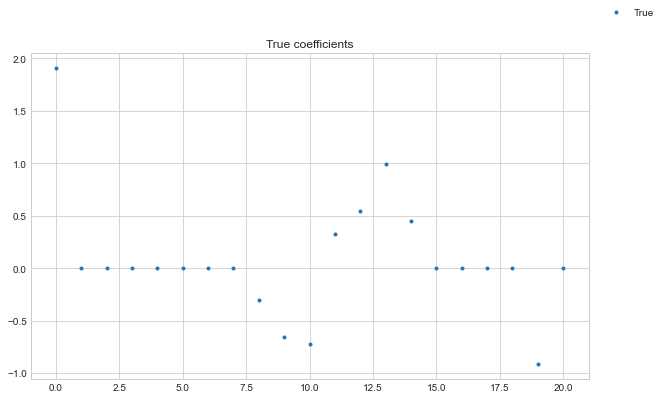

In [2]:
n = 100
m = 20
np.random.seed(10)

x = np.random.uniform(-1, 1, size=(n, m))
w = np.random.uniform(-1, 1, size=(m, 1))
b = np.random.normal(size=(1,1))
w = np.append(b, w * (np.random.uniform(size=(m, 1)) > 0.5), axis=0)
y_true = w[0] + x @ w[1:]
y = y_true + np.random.normal(loc=0, scale=2, size=(n, 1))

x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, ".", label="True")
ax.set_title("True coefficients")
fig.legend()
fig.show()

Next we prep data for PyTorch by converting to Tensors and
creating dataloaders.

We need to use the whole dataset in each step rather than smaller batches to match the way
sklearn has it's cost function setup.

In [3]:
from torch.utils.data import TensorDataset, DataLoader

x_train_t = torch.Tensor(x_train[:, np.newaxis])
y_train_t = torch.Tensor(y_train[:, np.newaxis])
x_test_t = torch.Tensor(x_test[:, np.newaxis])
y_test_t = torch.Tensor(y_test[:, np.newaxis])

dataset_train = TensorDataset(x_train_t, y_train_t)
dataloader_train = DataLoader(dataset_train, batch_size=x_train_t.shape[0], shuffle=True)
dataset_test = TensorDataset(x_test_t, y_test_t)
dataloader_test = DataLoader(dataset_test, batch_size=x_test_t.shape[0], shuffle=True)

## Model definition
Now let's create a PyTorch elastic net model with `pytorch-lightning`.

We create a single linear layer network which represents a linear model.
We need to support both L1 and L2 losses in order to create the elastic regularisation.
Note - both of those `l1_reg` and `l2_reg` methods do not include the intercept. [Why? - more details](https://stats.stackexchange.com/questions/86991/reason-for-not-shrinking-the-bias-intercept-term-in-regression?rq=1).

This loss comes together in the `training_step` where we simply add the loss function outputs.

In [4]:
import pytorch_lightning as pl

class ElasticLinear(pl.LightningModule):
    def __init__(
        self, loss_fn, n_inputs: int = 1, learning_rate=0.05, l1_lambda=0.05, l2_lambda=0.05
    ):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss_fn = loss_fn
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.output_layer = torch.nn.Linear(n_inputs, 1)
        self.train_log = []

    def forward(self, x):
        outputs = self.output_layer(x)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def l1_reg(self):
        l1_norm = self.output_layer.weight.abs().sum()

        return self.l1_lambda * l1_norm

    def l2_reg(self):
        l2_norm = self.output_layer.weight.pow(2).sum()
        
        return self.l2_lambda * l2_norm

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y) + self.l1_reg() + self.l2_reg()
        
        self.log("loss", loss)
        self.train_log.append(loss.detach().numpy())
        return loss

def plot_convergence(train_loss):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_loss)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Train loss')
    fig.show()

## Linear regression
First let's test the linear regression case, where we have no regularisation.
We fit the above model and plot the training loss to check for convergence.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 21    
-----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, loss=6.02, v_num=53]/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

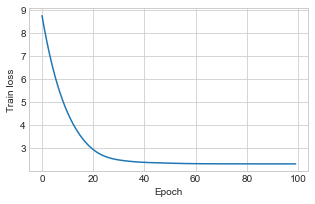

In [5]:
model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=x_train.shape[1],
    l1_lambda=0.0,
    l2_lambda=0.0,
    learning_rate=0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)

Now we fit an equivalent model in `sklearn`.

In [6]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression()
model_lin.fit(x_train, y_train)

LinearRegression()

Comparing the fitted coefficients we see that the models are nearly identical:

<ipython-input-7-1a7960f2f30d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


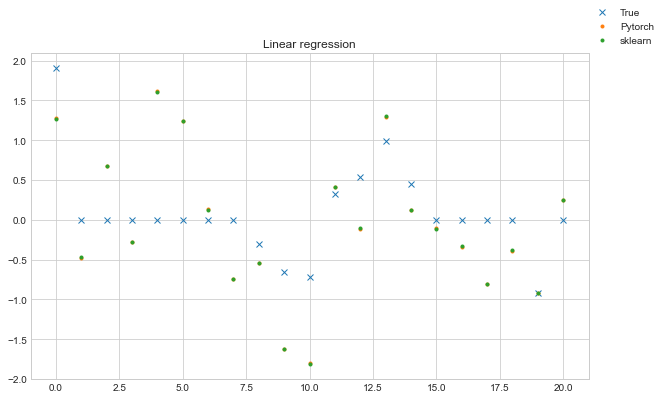

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, "x", label="True")
ax.plot(w_model, ".", label="Pytorch")
ax.plot(np.append(model_lin.intercept_, model_lin.coef_), ".", label="sklearn")
ax.set_title("Linear regression")
fig.legend()
fig.show()

## Ridge regression
Next let's test the ridge regression case, where we have only L2 regularisation.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 21    
-----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, loss=7.41, v_num=54]         /Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

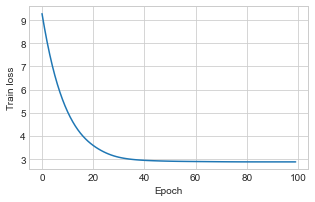

In [8]:
model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=x_train.shape[1],
    l1_lambda=0.00,
    l2_lambda=0.05,
    learning_rate=0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)

To fit an equivalent model in `sklearn` we need to adjust the regularisation value a bit.

$$loss = ||y - Xw||^2_2 + alpha * ||w||^2_2$$

Here `sklearn` doesnt use the MSE rather the SSE,
therefore we need to scale the alpha term by the training size to be consistent.

In [9]:
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha=0.05*x_train_t.shape[0])
model_ridge.fit(x_train, y_train)

Ridge(alpha=2.5)

Comparing the fitted coefficients once again we see that the models are nearly identical:

<ipython-input-10-07c5066c875c>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


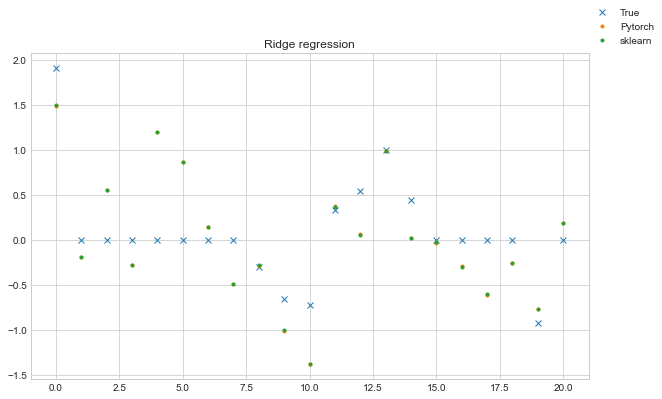

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, "x", label="True")
ax.plot(w_model, ".", label="Pytorch")
ax.plot(np.append(model_ridge.intercept_, model_ridge.coef_), ".", label="sklearn")
ax.set_title("Ridge regression")
fig.legend()
fig.show()

## Lasso regression
Next up is lasso regression case, where we have only L1 regularisation.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 21    
-----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, loss=7.57, v_num=55]         /Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

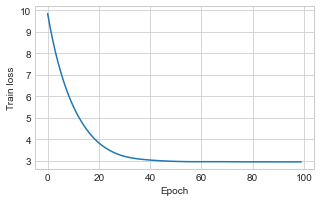

In [11]:
model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=x_train.shape[1],
    l1_lambda=0.05,
    l2_lambda=0.0,
    learning_rate=0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)

To fit an equivalent model in `sklearn` the alpha value we need is out by a factor of 2.

$$loss = (1 / (2 * n_{samples})) * ||y - Xw||^2_2 + alpha * ||w||_1$$

So we adjust the parameter appropriately.

In [12]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.05/2)
model_lasso.fit(x_train, y_train)

Lasso(alpha=0.025)

Comparing the fitted coefficients once again we see that the models are nearly identical:

<ipython-input-13-0f08a247de27>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


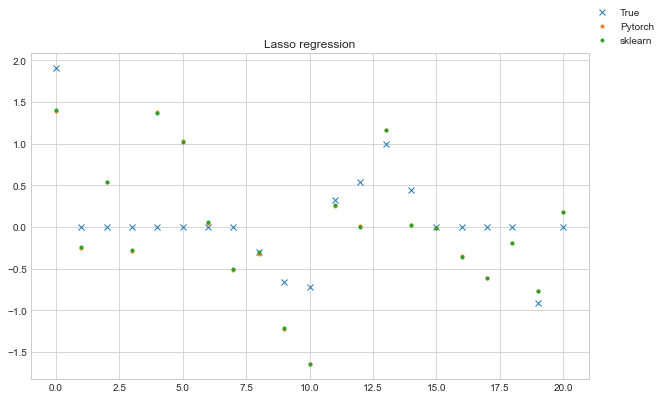

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, "x", label="True")
ax.plot(w_model, ".", label="Pytorch")
ax.plot(np.append(model_lasso.intercept_, model_lasso.coef_), ".", label="sklearn")
ax.set_title("Lasso regression")
fig.legend()
fig.show()

## ElasticNet regression
Finally we have the elastic net regression case, where we have both L1 and L2 regularisation.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 21    
-----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, loss=6.55, v_num=56]/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

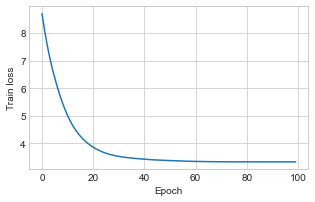

In [14]:
# ElasticNet
model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=x_train.shape[1],
    l1_lambda=0.05,
    l2_lambda=0.05,
    learning_rate=0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)

For `sklearn` the loss function is given as:

$$1 / (2 * n_{samples}) * ||y - Xw||^2_2$$
$$+ alpha * l1_{ratio} * ||w||_1$$
$$+ 0.5 * alpha * (1 - l1_{ratio}) * ||w||^2_2$$

To adjust the parameters we use the following:
```
a = 0.05 / 2
b = 0.05
alpha = a + b and l1_ratio = a / (a + b)
```

In [15]:
from sklearn.linear_model import ElasticNet
model_elastic = ElasticNet(alpha=0.075, l1_ratio=1/3)
model_elastic.fit(x_train, y_train)

ElasticNet(alpha=0.075, l1_ratio=0.3333333333333333)

And no surprises here that the fitted coefficients once again are nearly identical:

<ipython-input-16-fe6d54c07cff>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


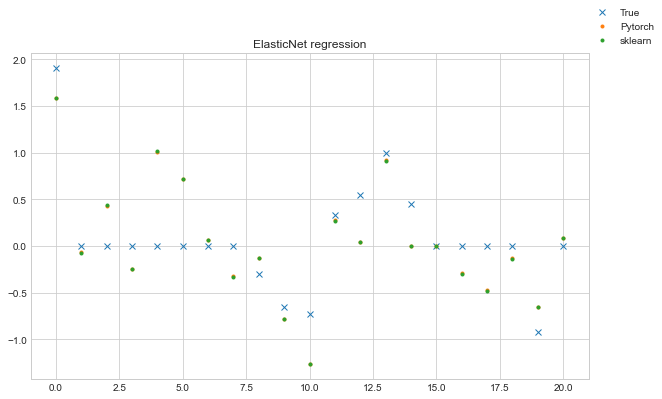

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, "x", label="True")
ax.plot(w_model, ".", label="Pytorch")
ax.plot(np.append(model_elastic.intercept_, model_elastic.coef_), ".", label="sklearn")
ax.set_title("ElasticNet regression")
fig.legend()
fig.show()